# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 

from matplotlib import rcParams
import seaborn as sns
import itertools
import scipy

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

## Load input data 

First we load sample annotations.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'

adata = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata = adata[adata.obs['sample'] == 'exper0',:]

reg_mod_name = 'RegressionGeneBackgroundCoverageTorch_51covariates_8111cells_12422geneswith_tissue_zones'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
design = adata.uns['design']['cell_types2zones']
design, adata_snrna_raw, adata

(                tissue_zone_0  tissue_zone_1  tissue_zone_2  tissue_zone_3  \
 Inh_3                0.000000       0.000000       0.934032       0.000000   
 Ext_Pir              0.000000       0.000000       0.000000       0.000000   
 Oligo_2              0.000000       0.661809       0.000000       0.000000   
 Astro_HYPO           0.000000       0.000000       0.000000       0.000000   
 Ext_L25              0.000000       0.000000       0.000000       0.000000   
 Astro_THAL_lat       0.000000       0.000000       0.000000       0.000000   
 Ext_L5_1             0.000000       0.000000       0.000000       0.000000   
 Ext_L23              0.000000       0.000000       0.000000       0.000000   
 Micro                0.000000       0.000000       0.000000       0.000000   
 Ext_Thal_1           0.000000       0.000000       0.000000       0.000000   
 Ext_Hpc_CA1          0.000000       0.000000       0.000000       0.000000   
 Inh_Meis2_3          0.000000       0.000000       

Add counts matrix as `adata.raw` 

In [3]:
# Select genes expressed by at least 2% of cells in each cluster.
adata_snrna_raw_bin = adata_snrna_raw.copy()
adata_snrna_raw_bin.X = adata_snrna_raw_bin.X > 0
adata_snrna_raw_bin.raw = adata_snrna_raw_bin
prop_expressed = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw_bin, 'annotation_1')
prop_expressed = prop_expressed.loc[adata_snrna_raw.var_names,:]
adata_snrna_raw = adata_snrna_raw[:, prop_expressed.max(1) > 0.02]

In [4]:
adata_vis = adata.copy()
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

from re import sub
adata_snrna_raw.obs['sample'] = [sub('_.+$','', i) for i in adata_snrna_raw.obs.index]

#### Plot numbers of cells per spot

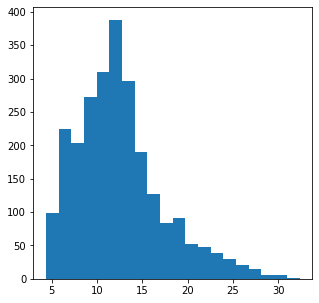

In [5]:
from re import sub
cell_count = adata_vis.obs.loc[:, ['cell_abundances_' in i for i in adata_vis.obs.columns]]
cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
cell_count_columns = cell_count.columns
umi_count = adata_vis.obs.loc[:, ['UMI_count_' in i for i in adata_vis.obs.columns]]
umi_count.columns =  [sub('UMI_count_', '', i) for i in umi_count.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist(cell_count.sum(1), bins=20);

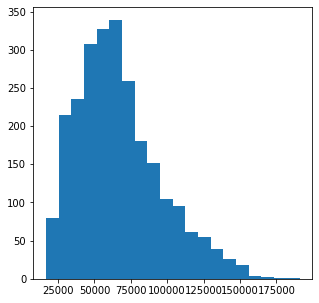

In [6]:
plt.hist(umi_count.sum(1), bins=20);

## Perform nnls

gen	nevals	pareto	correlation      	distance             
0  	100   	1     	1116.33 - 1116.33	486447.79 - 486447.79
1  	100   	1     	1116.33 - 1116.33	486447.79 - 486447.79


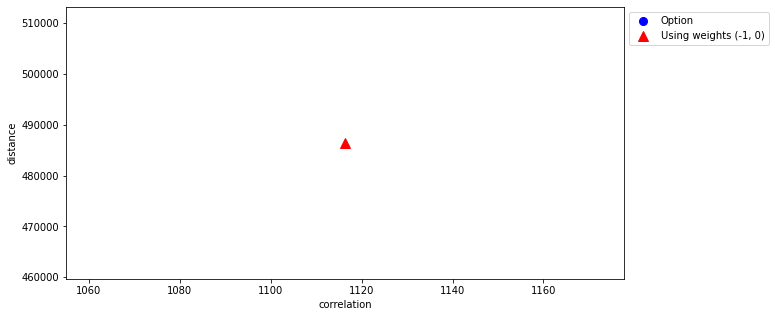

0.470563006401062 min
0.01922560135523478 min


In [8]:
import autogenes as ag

# Select all genes - just use the regression models
adata_snrna_raw.var['selected'] = True

# Initialise autogenes object
#ag.init(adata_snrna_raw, genes_key='selected', celltype_key='annotation_1')
averages = cell2location.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
intersect = np.intersect1d(adata_snrna_raw.var_names, adata_vis.var_names)
averages = averages.loc[intersect,:]
ag.init(averages.T)
# do not run the gene selection
ag.optimize(ngen=1,nfeatures=averages.shape[0],seed=0,mode='fixed')
ag.plot(weights=(-1,0))

# Deconvolve spatial data into single cell averages
start = time.time()
coef_nnls = ag.deconvolve(adata_vis.raw[:, averages.index].X.toarray(), #key='selected',
                          model='nnls')
print(str((time.time() - start) / 60) + ' min')

start = time.time()
coef_linear = ag.deconvolve(adata_vis.raw[:, averages.index].X.toarray(), #key='selected',
                            model='linear')
print(str((time.time() - start) / 60) + ' min')

#start = time.time()
#coef_nusvr = ag.deconvolve(adata_vis.raw[:, averages.index].X.toarray(), #key='selected',
#                           model='nusvr')
#str((time.time() - start) / 60) + ' min'

# save results to DF
coef_nnls_df = pd.DataFrame(coef_nnls.T, columns=adata_vis.obs_names, index=averages.columns)
#coef_nusvr_df = pd.DataFrame(coef_nusvr, columns=adata_vis.obs_names, index=averages.columns)
coef_linear_df = pd.DataFrame(coef_linear.T, columns=adata_vis.obs_names, index=averages.columns)

# write to disc
coef_nnls_df.to_csv(results_folder + f'autogenes_models/coef_nnls_seed.csv')
#coef_nusvr_df.to_csv(results_folder + 'autogenes_models/coef_nusvr_seed.csv')
coef_linear_df.to_csv(results_folder + f'autogenes_models/coef_linear_seed.csv')